In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats 
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

import platform
if platform.system() == 'Darwin' :
    plt.rc('font' , family = 'AppleGothic')
elif platform.system() == 'Window' :
    plt.rc('font', family = 'Malgun Gothic')

plt.rcParams['axes.unicode_minus']

import matplotlib as mpl  # 기본 설정 
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리

 
#apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
#apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'C:/Users/i2max-DoeunKim/Documents/jupyter_files/나눔 글꼴/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

In [143]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p1.csv',encoding= 'cp949')

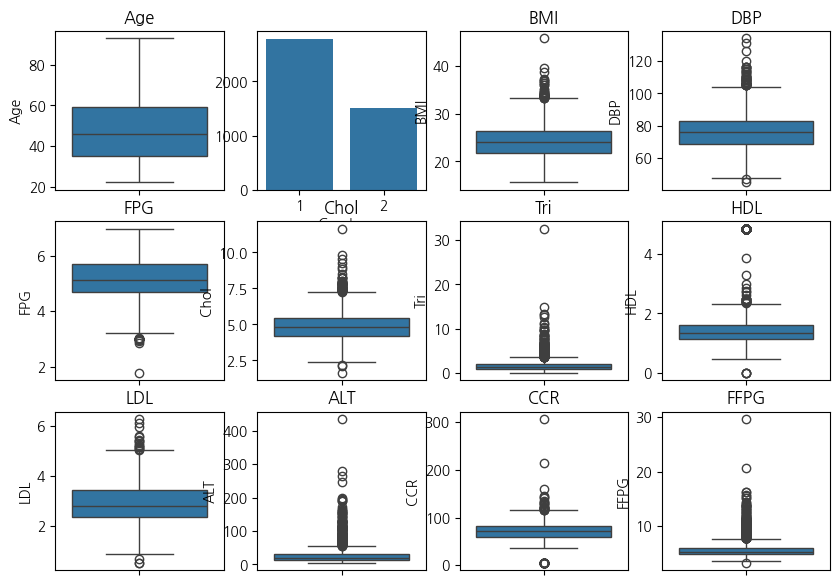

In [144]:
# EDA 
df = df.dropna()
df1 = df.copy()

fig, axes = plt.subplots(3,4, figsize=  (10, 7))

for i, ax in enumerate(axes.flat[:len(df1.columns)]) : 
    col_i = df1.columns[i]
    if col_i == 'Gender' : 
        target = df1[col_i].value_counts()
        sns.barplot(x = target.index, y = target.values, ax = ax)
    else :
        sns.boxplot(df1[col_i], ax = ax)
        ax.set_title(col_i)

<Axes: >

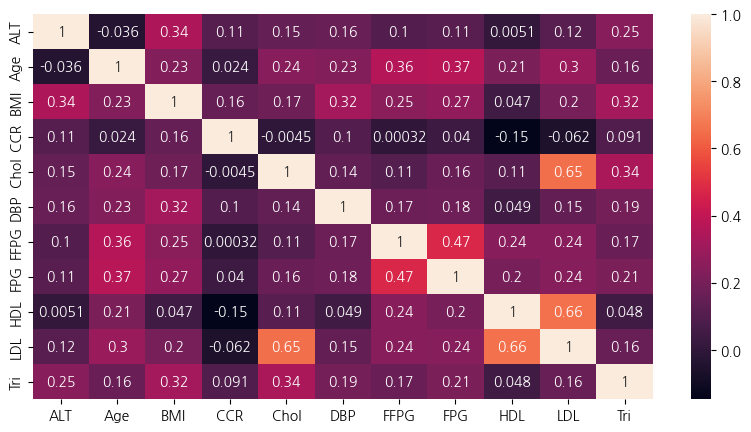

In [145]:
cor_df = df1[df1.columns.difference(['Gender'])].corr()

plt.figure(figsize = (10,5))
sns.heatmap(cor_df, annot = True)

### 1-2 데이터 전처리가 필요하다면 수행하고 이유를 작성

<Axes: >

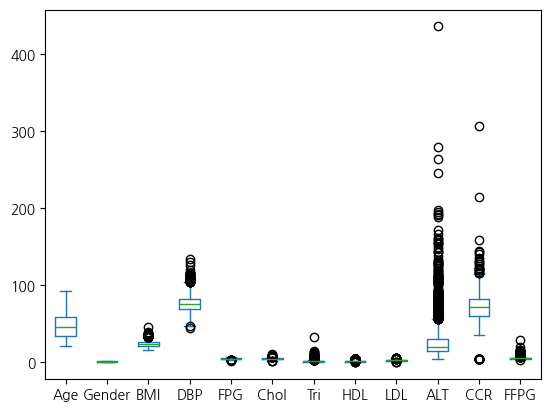

In [146]:
## 1) 이상치 제거 작업 
def outlier_remove(df) : 
    for col in df.columns : 
        if col != 'Gender' : 
            iqr = np.quantile(df[col], 0.75) - np.quantile(df[col], 0.25)
            upper = np.quantile(df[col], 0.75) + 1.5 * iqr
            lower = np.quantile(df[col], 0.25) - 1.5 * iqr

            df = df[(df[col] >= lower) &(df[col] < upper)]
            return df 

# 이상치 제거후의 df2 
df2 = outlier_remove(df1)
df2.plot(kind = 'box')

In [147]:
## 데이터의 단위의 차이가 있기 때문에, 분석을 위해 스케이링을 실행하여, 분류 모델에 적합한 MinMaxScaler를 사용한다. 
from sklearn.preprocessing import MinMaxScaler 

X = df2.drop(['DBP'], axis = 1)
y = df2['DBP']

mm = MinMaxScaler()
s_X = pd.DataFrame(mm.fit_transform(X) , columns = X.columns)

print(s_X.shape)
print(y.shape)

(4302, 11)
(4302,)


### train test set을 DBP컬럼 기준으로 7:3 비율로 나누고 잘 나뉘었는지 통계적으로 확인하라.

In [148]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(s_X, y, test_size = 0.3, random_state = 424)

## 컬럼이 여러개 
stat, p_val = stats.ttest_ind(y_train, y_test)
print("""
귀무가설 : 두 분포는 같다.
대립가설 : 두 분포는 다르다. 
""")
if p_val < 0.05 : 
    print(f"{p_val}-귀무가설을 기각하여, 두 분포가 다르다")
else : 
     print(f"{p_val}-귀무가설을 채택하여, 두 분포는 같다")


귀무가설 : 두 분포는 같다.
대립가설 : 두 분포는 다르다. 

0.5197892724546394-귀무가설을 채택하여, 두 분포는 같다


독립변수의 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거

In [149]:
## 1. 다중공선성 : 설명 변수간에 높은 상관관계가 있을 경우 모델 성능이 저하 될 수 있다. 
## 2. PCA : 모든 변수가 고르게 데이터의 분산을 설명하거나, 기여도 높은 경우 차원 축소가 불필요하다.
# 만약 상위 몇 개이 주성분이 전체 데이터의 분산을 설명한다면 나머지 주성분들은 모델에서 중요한 역량을 하지 않기
# 때문에 차원을 줄일 수 있다. 

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
ratio,0.579333,0.188606,0.098218,0.044634,0.040484,0.024760,0.006401,0.005495,0.004879,0.004692,0.0025
cumsum,0.579333,0.767938,0.866156,0.910790,0.951274,0.976034,0.982435,0.987930,0.992809,0.997500,1.0000


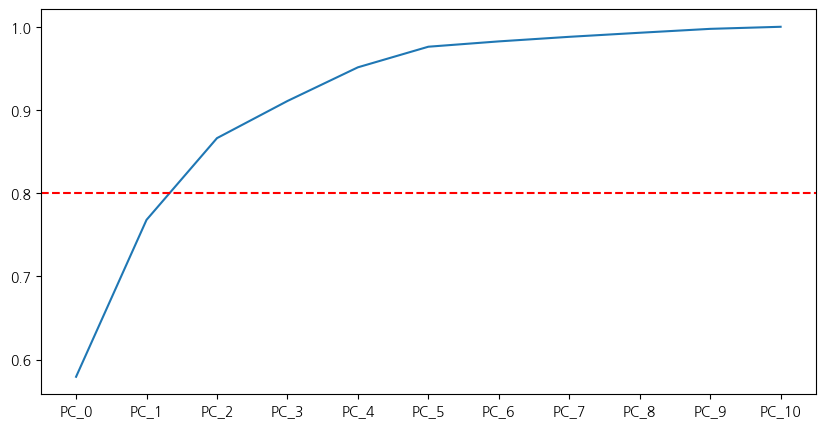

In [150]:
from sklearn.decomposition import PCA

# Scaler가 된 변수 사용 
pca = PCA()
pca.fit(s_X)

pca_df= pd.DataFrame(
                    {'ratio' : pca.explained_variance_ratio_ , 
                     'cumsum' : pca.explained_variance_ratio_.cumsum()    
                    })
pca_df.index =['PC_' + str(x) for x in pca_df.index]

display(pca_df.T)
plt.figure(figsize = (10, 5))
plt.plot(pca_df['cumsum'])
plt.axhline(0.8, color = 'r', linestyle = '--') 

In [179]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

vif = pd.DataFrame()
vif['factors'] = s_X.columns 
vif['VIF'] = [variance_inflation_factor(s_X.values , i) for i in range(s_X.shape[1])]
vif

,factors,VIF
0,Age,5.515563
1,Gender,2.027681
2,BMI,9.748112
3,FPG,23.767997
4,Chol,36.296130
5,Tri,3.431853
6,HDL,8.922377
7,LDL,39.479722
8,ALT,2.459262
9,CCR,13.789824


# 회귀 분석의 기본 가정
1) 선형성 - 종속 변수와 독립 변수는 선형 관계에 있따
2) 독립성 : 데이터는 독립적이다
3) 등분산 : 잔차의 분산은 일정하다
4) 정규성 : 정규 분포를 따른다. 

In [151]:
import statsmodels.api as sm 

c_X = sm.add_constant(s_X.reset_index(drop = True))
model = sm.OLS(y.reset_index(drop =True), c_X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    DBP   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     70.69
Date:                Sat, 05 Oct 2024   Prob (F-statistic):          2.69e-146
Time:                        22:08:42   Log-Likelihood:                -16063.
No. Observations:                4302   AIC:                         3.215e+04
Df Residuals:                    4290   BIC:                         3.223e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.2800      1.225     53.271      0.0

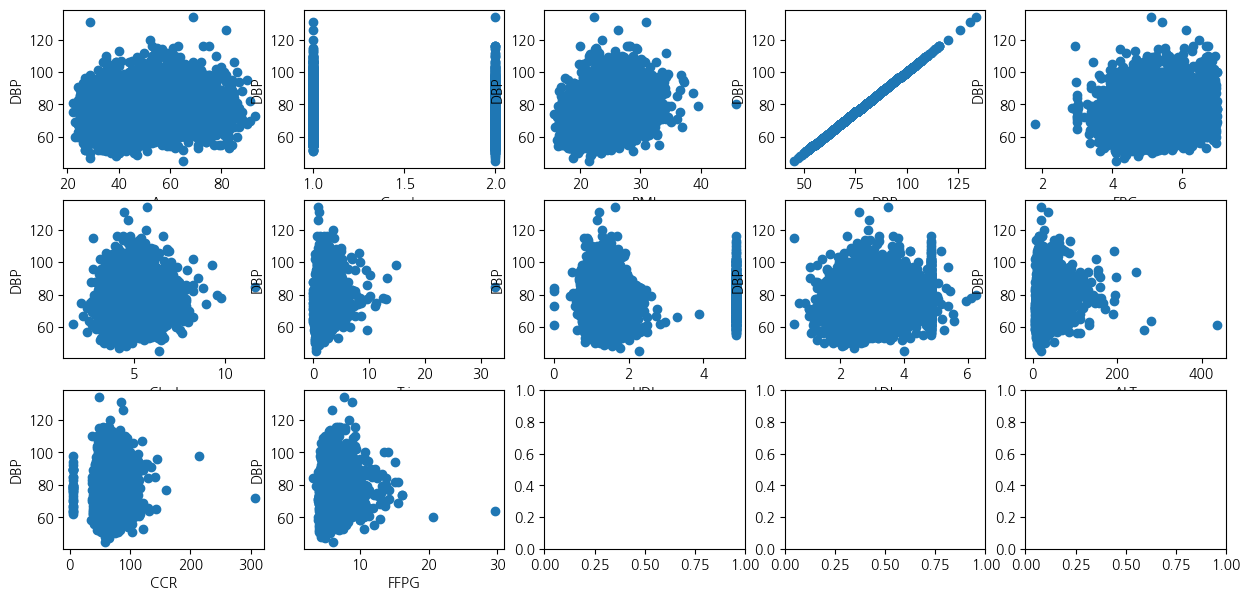

In [152]:
## 1. 선형성 
fig, axes = plt.subplots(3,5, figsize = (15,7))

for i, ax in enumerate(axes.flat[:-3]) : 
    ax.scatter(df[df.columns[i]], df['DBP'])
    ax.set_xlabel(str(df.columns[i]))
    ax.set_ylabel('DBP')
plt.show() 

<Axes: >

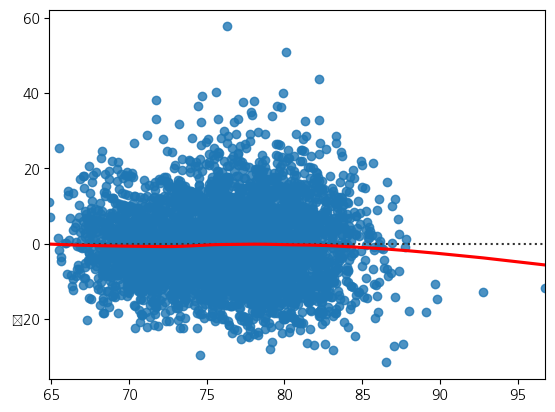

In [153]:
## 2. 선형성 : 예측과 잔차의 관계에서 잔차가 특정 패텀 없이 무작위로 분포되면 선형성이 유지되는 것으로 판단.
fitted = model.fittedvalues #예측값
resid = model.resid  # 잔차

sns.residplot(x=fitted, y=resid, lowess=True, line_kws={'color': 'red'})

In [154]:
## 3. 독립성 
from statsmodels.stats.stattools import durbin_watson
durbin = durbin_watson(resid)
print(durbin)
print("2에 가깝다면 자기 상관이 없다고, 독립적")

1.9900655576943755
2에 가깝다면 자기 상관이 없다고, 독립적


1.0091313496782335e-13


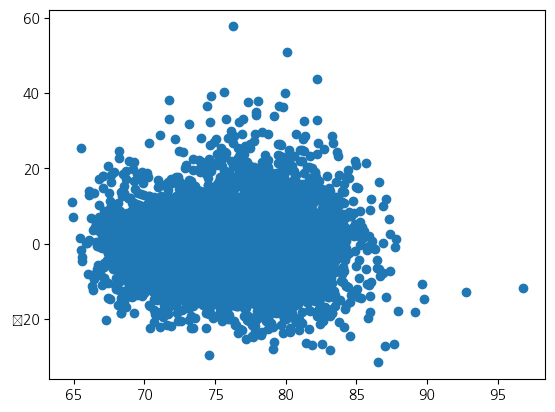

In [155]:
## 4. 등분산성 
# 귀무가설 : 등분산이다.
# 대립가설 : 등분산이 아니다. 
import statsmodels.stats.api as sms 
stats, p_val , f_sta, f_pv = sms.het_breuschpagan(resid, model.model.exog)
print(p_val)

plt.scatter(fitted, resid)
plt.show()

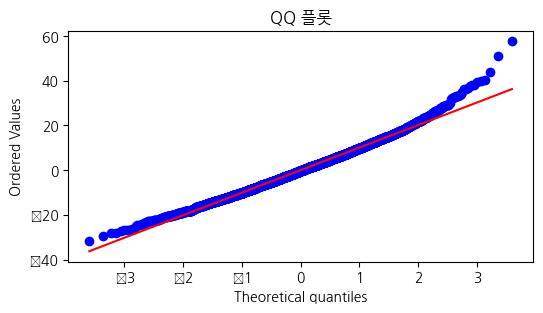

In [158]:
## 5. 잔차의 정규성 
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, ax = plt.subplots(figsize = (6,3))
stats.probplot(resid, dist= 'norm', plot = ax)
ax.set_title("QQ 플롯")
plt.show()

1-3에서 구분한 데이터를 기준으로 3개의 회귀 분석 모델링을 진행하고 평가지표 rmse로 가장 최적화된 알고리즘 선정

In [165]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor 
from sklearn.metrics import mean_squared_error


lr = LinearRegression()
rf = RandomForestRegressor()
xgb = XGBRFRegressor()

lst = {}
model_lst = []
def modelling(model, name) :
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    acc = np.sqrt(mean_squared_error(pred, y_test))
    return {name : acc} , model 

for models in ([lr, 'Linear Regressor'], [rf , 'Random Foreset'] , [xgb, 'XGBRFRegressor']) : 
    model = models[0]
    name = models[1]
    acc, model = modelling(model, name)
    lst.update(acc)
    model_lst.append(model)

pd.DataFrame(lst.items() , columns = ['Model', 'RMSE'])

,Model,RMSE
0,Linear Regressor,10.337765
1,Random Foreset,10.558143
2,XGBRFRegressor,10.414167


3-3 가장 최적화된 알고리즘을 이용하여 K-Fold 교차검증을 수행

In [173]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=5, shuffle= True, random_state = 33)
score = cross_val_score(lr, s_X, y , scoring = 'neg_mean_squared_error' , cv = kfold)
mse = -score

pd.DataFrame({
    'Fold_number' : range(1 , len(mse) + 1), 
    'MSE' : mse   
})

,Fold_number,MSE
0,1,108.640662
1,2,101.019665
2,3,95.709513
3,4,97.999296
4,5,112.613846


In [166]:
s_X

,Age,Gender,BMI,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
0,0.056338,0.0,0.149007,0.771593,0.271,0.026348,0.185156,0.329843,0.017373,0.195073,0.083019
1,0.253521,0.0,0.069536,0.541267,0.205,0.031250,0.308594,0.261780,0.010887,0.216586,0.033962
2,0.253521,1.0,0.135762,0.675624,0.422,0.039522,0.360027,0.493892,0.012972,0.186137,0.062264
3,0.295775,0.0,0.248344,0.522073,0.240,0.022672,0.261276,0.359511,0.074126,0.226847,0.079245
4,0.197183,0.0,0.360927,0.721689,0.504,0.106924,0.187214,0.541012,0.150104,0.207319,0.087925
...,...,...,...,...,...,...,...,...,...,...,...
4297,0.450704,0.0,0.258278,0.967370,0.335,0.045956,0.255105,0.425829,0.008107,0.238762,0.132075
4298,0.394366,1.0,0.221854,0.679463,0.272,0.064032,0.281849,0.305410,0.038684,0.140463,0.126415
4299,0.633803,0.0,0.298013,0.589251,0.224,0.042279,0.234532,0.284468,0.031503,0.217579,0.135849
4300,0.535211,1.0,0.443709,0.944338,0.426,0.039522,0.355912,0.403141,0.033356,0.150061,0.143396


In [106]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p2_v2.csv')
df.head()

,사고년도,가해자성별,가해자연령,가해차종,가해자신체상해정도,피해자성별,피해자연령,피해차종,피해자신체상해정도,사고유형,가해자법규위반,기상상태,시각,사건번호
0,2015,남,46세,승합차,상해없음,여,64세,자전거,경상,차대차 - 기타,안전운전불이행,맑음,2015-07-03_10시,ID_796
1,2019,남,53세,승용차,상해없음,여,57세,자전거,경상,차대차 - 후진중충돌,안전운전불이행,맑음,2019-10-12_10시,ID_6697
2,2015,남,39세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,기타,맑음,2015-03-23_20시,ID_919
3,2016,남,12세,자전거,상해없음,남,52세,보행자,경상,차대사람 - 길가장자리구역통행중,안전운전불이행,맑음,2016-04-10_15시,ID_2512
4,2015,남,54세,승용차,상해없음,남,63세,자전거,중상,차대차 - 기타,안전운전불이행,맑음,2015-08-04_6시,ID_75


In [107]:
df['시각'] = pd.to_datetime(df['시각'],format='%Y-%m-%d_%H시')
df['주말여부']= df['시각'].dt.weekday.map(lambda x : '주말' if x >=5 else '평일')

발생시각을 통해 평일인지 주말인지를 구분하는 '주말여부' 범주형 변수 추가하고 데이터 분포를 확인하라. (월 ~ 금은 평일, 토요일과 일요일을 주말)

In [108]:
df1 = df[(df['가해자연령'] != '불명' )& (df['피해자연령'] != '불명' )]
df1['가해자연령'] = df1['가해자연령'].str.split('세').str[0].astype(int)
df1['피해자연령'] = df1['피해자연령'].str.split('세').str[0].astype(int)

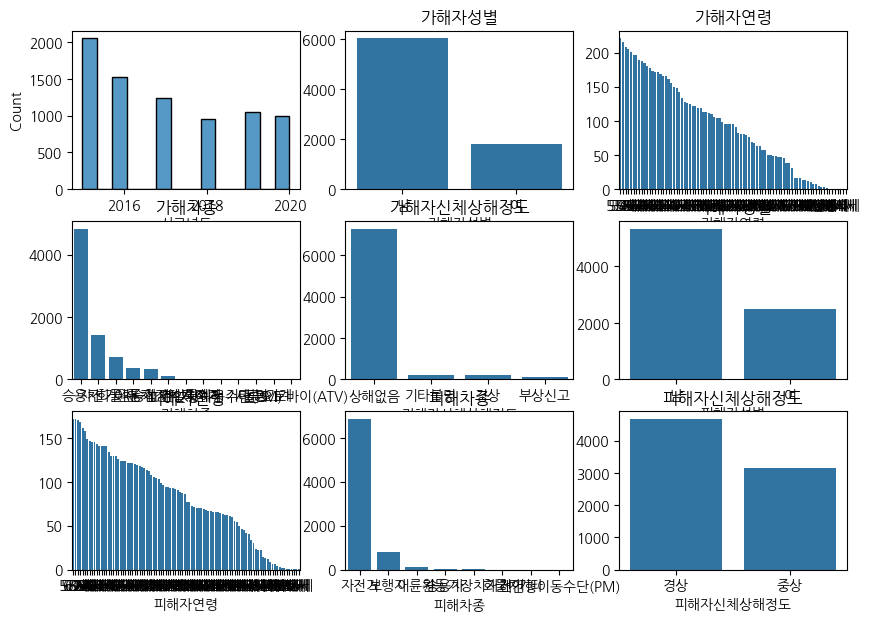

In [109]:
plot_cols = df1.columns 

fig, axes = plt.subplots(3,3 ,figsize = (10, 7))

for i, ax in enumerate(axes.flat[:]) : 
    col_i = df1[plot_cols].columns[i]
    if df[col_i].dtypes == 'object' :
        target = df[col_i].value_counts()
        sns.barplot(x = target.index, y = target.values, ax = ax)
        ax.set_title(col_i)
    else : 
        sns.histplot(df[col_i] , ax = ax)
       

In [110]:
df1.columns
test_df = df1.drop(['사건번호','시각'], axis = 1)
test_df['사고년도'] = test_df['사고년도'].astype('object')

주말여부에 따라 각 변수들(사고내용,가해자성별,가해자연령,기상상태,사고유형)이 유의한지 통계적 검정

In [111]:
from scipy.stats import chi2_contingency


lst = []
for col in test_df.columns : 
    if test_df[col].dtype == 'object'  : 
        target = pd.crosstab(test_df[col], test_df['피해자신체상해정도'])
        stat, p_val , dof, expected = stats.chi2_contingency(target)
        lst.append([col, p_val])

    elif test_df[col].dtype == 'int' : 
        stat, p_val = stats.ttest_ind(test_df.query("피해자신체상해정도 == '경상'")[col],\
                                      test_df.query("피해자신체상해정도 == '중상'")[col]  )
        lst.append([col, p_val])


table = pd.DataFrame(lst, columns = ['cols', 'p_val'])
table['check'] = table['p_val'].apply(lambda x :'유의' if x > 0.05 else '유의하지않음')
table
#list(table[table['check'] == '유의']['cols'])


,cols,p_val,check
0,사고년도,2.037122e-01,유의
1,가해자성별,4.583715e-01,유의
2,가해자연령,9.587908e-01,유의
3,가해차종,4.153636e-05,유의하지않음
4,가해자신체상해정도,3.668284e-02,유의하지않음
5,피해자성별,9.462348e-06,유의하지않음
6,피해자연령,2.488670e-80,유의하지않음
7,피해차종,1.151194e-03,유의하지않음
8,피해자신체상해정도,0.000000e+00,유의하지않음
9,사고유형,5.716531e-03,유의하지않음


유의한 변수들만을 가지고 '피해자신체상해정도'를 기준으로 SMOTE 오버샘플링을 수행하고 샘플링 데이터와 기존데이터를 합친 전체 데이터에 대해 범주형변수는 변수별 빈도를 나타내고 연속형이면 평균을 나타내시오

In [113]:
## 유의한 변수들 선택 
cols = list(table[table['check'] == '유의']['cols'])
f_df = df1[['사고년도', '가해자성별' ,'가해자연령', '기상상태','주말여부', '피해자신체상해정도']]
f_df['사고년도'] = f_df['사고년도'].astype('object')
f_df

,사고년도,가해자성별,가해자연령,기상상태,주말여부,피해자신체상해정도
0,2015,남,46,맑음,평일,경상
1,2019,남,53,맑음,주말,경상
2,2015,남,39,맑음,평일,중상
3,2016,남,12,맑음,주말,경상
4,2015,남,54,맑음,평일,중상
...,...,...,...,...,...,...
7821,2017,여,60,맑음,평일,경상
7822,2018,여,62,맑음,평일,중상
7823,2020,남,44,맑음,평일,경상
7824,2016,남,61,맑음,평일,경상


In [115]:
# 분석을 위한 라벨 인코딩 
from sklearn.preprocessing import LabelEncoder

for col in f_df.columns : 
    le = LabelEncoder()
    f_df[col] = le.fit_transform(f_df[col])

## SMOTE 전 분류 
x = f_df.drop('피해자신체상해정도', axis = 1)
y = f_df['피해자신체상해정도']

In [118]:
from imblearn.over_sampling import SMOTE 

## SMOTE 전 분류 
x = f_df.drop('피해자신체상해정도', axis = 1)
y = f_df['피해자신체상해정도']

## SMOTE 적용 분류 
smote = SMOTE()
s_x , s_y = smote.fit_resample(x, y)

## 샘플링, 기존 데이터 병합 
concat_x = pd.concat([x, s_x], axis =0).reset_index(drop =True)

# 범주형은 빈도, 연속형은 평균 
for col in concat_x.columns : 
    if col == '가해자연령' :
        print(f"{col} 연속형 변수 :{concat_x[col].mean()}")

    else : 
        print(concat_x[col].value_counts())

사고년도
0    4536
1    3384
2    2722
4    2301
5    2137
3    2099
Name: count, dtype: int64
가해자성별
0    13301
1     3878
Name: count, dtype: int64
가해자연령 연속형 변수 :40.0736364165551
기상상태
0    16265
1      480
2      434
Name: count, dtype: int64
주말여부
1    13035
0     4144
Name: count, dtype: int64


데이터를 가지고 '피해자신체상해정도' 을 종속변수로 하여 로지스틱회귀분석, XGB 분류 분류 모델을 만들고 성능 비교를 하고 영향력 있는 변수를 확인

In [120]:
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , accuracy_score 

## 분할 
x_train, x_test, y_train, y_test = train_test_split(s_x, s_y, test_size = 0.3, random_state= 123)

## 모델 
lr = LogisticRegression()
xg = xgboost.XGBClassifier()

lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_score = accuracy_score(y_test, lr_pred)


xg.fit(x_train, y_train)
xg_pred = xg.predict(x_test)
xg_score = accuracy_score(y_test, xg_pred)

print(lr_score, xg_score)

0.5147844674029213 0.539365871036694


<BarContainer object of 5 artists>

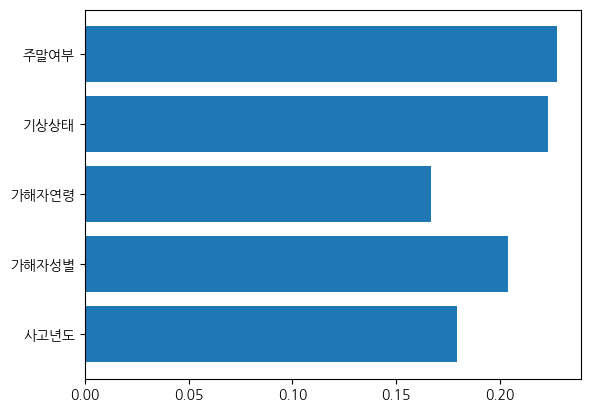

In [121]:
## 영향력 있는 변수 확인 
plt.barh(xg.feature_names_in_ , xg.feature_importances_)

데이터 설명
데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p6.csv
데이터 설명 : 3개 연령층 (청년 장년 노년)의 A 헤드셋의 선호도 (1,2,3/ 범주형) 설문조사

6.1 연령대별로 헤드셋 선호도에 차이가 있는지를 검정하기 위한 귀무가설과 연구가설을 설정해라.

In [126]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p6.csv')

print(df['나이'].value_counts())
print(df['선호도'].value_counts())

cross = pd.crosstab(df['나이'], df['선호도'])
stat, p_val , df, expected = chi2_contingency(cross)
print(p_val)

나이
청년    120
노년     92
장년     65
Name: count, dtype: int64
선호도
1    107
2     99
3     71
Name: count, dtype: int64
0.9919538273457956


In [129]:
# 아이를 6명 가진 가정이 5 가족이고, 아들/딸을 출생할 확률은 0.5
from scipy.stats import binom 

#딸이 4명 이상인 가구가 3 가족 이상일 확률
n = 6
p = 0.5
rv = binom(n,p)

# 1) 아이 6명 중 딸이 4명 이상일 확률 
d_4 = 1 - rv.cdf(3)

# 2) 5가족 중에 3가족 이상일 확률 
rv2= binom(5, d_4)
1 - rv2.cdf(2)

np.float64(0.2255459427833557)

7.2 5가족 중 몇 가족이 4명 이상 딸을 가질 것으로 기대할 수 있는가? (소숫점 이하 4번째 자리에서 반올림)

In [131]:
rv2.mean()

np.float64(1.71875)